In [1]:
# 测试EfficientNet

import sys
import math
import itertools

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable, Function
import torchvision.models as models
import numpy as np

from src.models.EfficientNet import EfficientNet as EffNet

In [2]:
# EfficientNet_decoder

def EfficientNet(pretrained=False, **kwargs):
    model = Efficient_decoder(num_class=4, phi=0, load_weights=True)
    return model

class upsample(nn.Module):

    def __init__(self, if_deconv=True, channels=None):
        super(upsample, self).__init__()
        if if_deconv:
            self.upsample = nn.ConvTranspose2d(channels, channels, 4, stride=2, padding=1, bias=False)
        else:
            self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.upsample(x)
        return x

class change_channel(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(change_channel, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class Efficient_decoder(nn.Module):
    def __init__(self, num_class, phi=0, load_weights=False):
        super(Efficient_decoder, self).__init__()
        self.backbone = EffNet.from_pretrained(f'efficientnet-b{phi}', load_weights)
        #self.ratio_convert = nn.Conv2d(in_channels=1280, out_channels=640, kernel_size=(1,4), stride=(1,2), padding=(0,1))
        #self.ratio_convert = nn.Conv2d(in_channels=320, out_channels=640, kernel_size=(1,4), stride=(1,2), padding=(0,1))
        
        self.up1 = upsample(if_deconv=True, channels=320)  #恢复图像大小,8->16
        self.change_channel1 = change_channel(320, 256)
        self.up2 = upsample(if_deconv=True, channels=256)  #恢复图像大小,16->32
        self.change_channel2 = change_channel(256, 128)
        self.up3 = upsample(if_deconv=True, channels=128)  #恢复图像大小,32->64
        self.change_channel3 = change_channel(128, 64)
        self.conv_out_1 = nn.Conv2d(64, num_class, 3, padding=1)
        self.conv_out_2 = nn.Conv2d(64, num_class, 3, padding=1)

    def decoder(self, x):
        x = self.up1(x)   #([N, 640, 16, 16])
        x = self.change_channel1(x)   #([N, 256, 16, 16])
        
        x = self.up2(x)   #([N, 256, 32, 32])
        x = self.change_channel2(x)   #([N, 128, 32, 32])
        
        x = self.up3(x)   #([N, 128, 64, 64])
        x = self.change_channel3(x)   #([N, 64, 64, 64])
        
        x1 = self.conv_out_1(x)
        x2 = self.conv_out_2(x)
        return x1, x2

    def forward(self, x):
        x = self.backbone.extract_features(x)  # 输出维度（N，1280, H/32, W/32），其中H，W为原图像的高和宽，实验中输入原图像的尺寸为（256, 512），输出（8,16）（
        print("x.shape after backbone extract_features: ", x.shape)
        #x = self.ratio_convert(x)   #输出维度（N，640, H/32, W/64） 高和宽比例1：1,实验中得到（N，640,8,8）
        out1, out2 = self.decoder(x)
        return out1, out2

In [5]:
# 随机input测试
device = torch.device("cuda:0")
input_tensor = torch.randn(1,9,450,800).to(device)
model = EfficientNet().to(device)
output = model(input_tensor)
print(output[0].shape)

Loaded pretrained weights for efficientnet-b0


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 9, 451, 801] to have 3 channels, but got 9 channels instead

In [ ]:
# 载入nuscenes图像测试
from argparse import ArgumentParser
from src.data.data_factory import build_dataloaders
from src.utils.configs import get_default_configuration
from src.data.utils import create_visual_anno
from matplotlib import pyplot as plt

# Load the configuration for this experiment
def get_configuration(args):

    # Load config defaults
    config = get_default_configuration()

    # Load dataset options
    config.merge_from_file(f'configs/datasets/{args.dataset}.yml')


    # Restore config from an existing experiment
    if args.resume is not None:
        config.merge_from_file(os.path.join(args.resume, 'config.yml'))
    
    # Override with command line options
    config.merge_from_list(args.options)

    # Finalise config
    config.freeze()

    return config

In [ ]:
parser = ArgumentParser()
parser.add_argument('--tag', type=str, default='run',
                    help='optional tag to identify the run')
parser.add_argument('--dataset', choices=['nuscenes', 'argoverse'],
                    default='nuscenes', help='dataset to train on')
parser.add_argument('--model', choices=['pyramid', 'vpn', 'ved'],
                    default='pyramid', help='model to train')
parser.add_argument('--experiment', default='test', 
                    help='name of experiment config to load')
parser.add_argument('--resume', default=None, 
                    help='path to an experiment to resume')
parser.add_argument('--options', nargs='*', default=[],
                    help='list of addition config options as key-val pairs')
args = parser.parse_args(args=['--tag', 'run',  '--dataset', 'nuscenes', '--model', 'pyramid',
                               '--experiment', 'test'])

# Load configuration
config = get_configuration(args)
print(config)

In [ ]:
train_loader, val_loader = build_dataloaders(config.train_dataset, config)
train_data = next(iter(train_loader))
img_sequence = train_data[0]
labels = train_data[2]
name_sequence = train_data[3]

img_1 = img_sequence[0][0]
img_2 = img_sequence[1][0]
img_3 = img_sequence[2][0]  #(3,450,800)
print("img shape: ", img_1.shape)

In [ ]:
#img = torch.from_numpy(img_1)
input_img = torch.unsqueeze(img_1, 0).to(device)
print(input_img.shape)

In [ ]:
out = model(input_img)
print(out[0].shape)

In [ ]:
def test(name="GS", job='worker', hard=True):
    print("name is {}, his job is {}, is his job hard? {}".format(name, job, hard))
    
test('WMH', hard=False)
test('WMH', False)
test("WMH",,False)

In [7]:
pts = np.array([[100,50],[200,300],[70,200],[50,100]],np.int32)
[pts]

[array([[100,  50],
        [200, 300],
        [ 70, 200],
        [ 50, 100]], dtype=int32)]

In [11]:
init_pts = [(1,100),(100,100),(100,1),(1,1)]
pts = np.array(init_pts, np.int32)
pts = pts.reshape((-1,1,2))
print(pts)

[[[  1 100]]

 [[100 100]]

 [[100   1]]

 [[  1   1]]]


In [12]:
points = np.array([[231,56],[1061,69],[1066,611],[217,602]], np.int32)
points.shape

(4, 2)

In [16]:
test_pt = (231, 56)
pt = np.array(test_pt, np.float32)
a = np.append(pt, 1)
print(type(test_pt))
a

<class 'tuple'>


array([231.,  56.,   1.])

In [1]:
# 测试train val test划分

In [5]:
from src.data.nuscenes.splits import TRAIN_SCENES, VAL_SCENES, CALIBRATION_SCENES
#print(VAL_SCENES)

In [10]:
# TRAIN_SCENES 689个 VAL_SCENES 148个，TEST_SCENES 150个  CALIBRATION_SCENES 50个
TEST_SCENES = \
    ['scene-0077', 'scene-0078', 'scene-0079', 'scene-0080', 'scene-0081', 'scene-0082', 'scene-0083', 'scene-0084',
     'scene-0085', 'scene-0086', 'scene-0087', 'scene-0088', 'scene-0089', 'scene-0090', 'scene-0091', 'scene-0111',
     'scene-0112', 'scene-0113', 'scene-0114', 'scene-0115', 'scene-0116', 'scene-0117', 'scene-0118', 'scene-0119',
     'scene-0140', 'scene-0142', 'scene-0143', 'scene-0144', 'scene-0145', 'scene-0146', 'scene-0147', 'scene-0148',
     'scene-0265', 'scene-0266', 'scene-0279', 'scene-0280', 'scene-0281', 'scene-0282', 'scene-0307', 'scene-0308',
     'scene-0309', 'scene-0310', 'scene-0311', 'scene-0312', 'scene-0313', 'scene-0314', 'scene-0333', 'scene-0334',
     'scene-0335', 'scene-0336', 'scene-0337', 'scene-0338', 'scene-0339', 'scene-0340', 'scene-0341', 'scene-0342',
     'scene-0343', 'scene-0481', 'scene-0482', 'scene-0483', 'scene-0484', 'scene-0485', 'scene-0486', 'scene-0487',
     'scene-0488', 'scene-0489', 'scene-0490', 'scene-0491', 'scene-0492', 'scene-0493', 'scene-0494', 'scene-0495',
     'scene-0496', 'scene-0497', 'scene-0498', 'scene-0547', 'scene-0548', 'scene-0549', 'scene-0550', 'scene-0551',
     'scene-0601', 'scene-0602', 'scene-0603', 'scene-0604', 'scene-0606', 'scene-0607', 'scene-0608', 'scene-0609',
     'scene-0610', 'scene-0611', 'scene-0612', 'scene-0613', 'scene-0614', 'scene-0615', 'scene-0616', 'scene-0617',
     'scene-0618', 'scene-0619', 'scene-0620', 'scene-0621', 'scene-0622', 'scene-0623', 'scene-0624', 'scene-0827',
     'scene-0828', 'scene-0829', 'scene-0830', 'scene-0831', 'scene-0833', 'scene-0834', 'scene-0835', 'scene-0836',
     'scene-0837', 'scene-0838', 'scene-0839', 'scene-0840', 'scene-0841', 'scene-0842', 'scene-0844', 'scene-0845',
     'scene-0846', 'scene-0932', 'scene-0933', 'scene-0935', 'scene-0936', 'scene-0937', 'scene-0938', 'scene-0939',
     'scene-0940', 'scene-0941', 'scene-0942', 'scene-0943', 'scene-1026', 'scene-1027', 'scene-1028', 'scene-1029',
     'scene-1030', 'scene-1031', 'scene-1032', 'scene-1033', 'scene-1034', 'scene-1035', 'scene-1036', 'scene-1037',
     'scene-1038', 'scene-1039', 'scene-1040', 'scene-1041', 'scene-1042', 'scene-1043']

In [17]:
# 求TRAIN_SCENES和TEST_SCENES的交集

#set(TRAIN_SCENES).intersection(set(TEST_SCENES))
len(set(VAL_SCENES).intersection(set(TEST_SCENES)))

0

In [19]:
from random import sample

NEW_VAL = sample(TRAIN_SCENES, 150)

In [22]:
print(NEW_VAL)

['scene-0559', 'scene-0446', 'scene-0193', 'scene-0457', 'scene-0813', 'scene-0183', 'scene-0453', 'scene-0561', 'scene-0354', 'scene-0585', 'scene-0635', 'scene-0922', 'scene-0134', 'scene-0328', 'scene-1054', 'scene-0108', 'scene-0653', 'scene-1025', 'scene-1084', 'scene-1088', 'scene-0479', 'scene-0662', 'scene-0288', 'scene-0886', 'scene-0872', 'scene-0661', 'scene-0057', 'scene-1020', 'scene-0095', 'scene-0784', 'scene-0402', 'scene-0381', 'scene-0594', 'scene-1052', 'scene-1044', 'scene-0331', 'scene-0240', 'scene-0360', 'scene-0808', 'scene-0903', 'scene-0926', 'scene-0171', 'scene-0173', 'scene-0128', 'scene-0228', 'scene-0781', 'scene-1079', 'scene-0162', 'scene-0819', 'scene-0992', 'scene-0921', 'scene-0806', 'scene-0877', 'scene-0792', 'scene-0304', 'scene-0423', 'scene-0318', 'scene-0427', 'scene-0222', 'scene-0880', 'scene-0172', 'scene-0627', 'scene-0659', 'scene-0094', 'scene-0502', 'scene-0251', 'scene-0023', 'scene-0125', 'scene-0524', 'scene-0295', 'scene-1045', 'scen

In [29]:
a = ['scene-0559', 'scene-0446', 'scene-0193', 'scene-0457', 'scene-0813', 'scene-0183', 'scene-0453', 'scene-0561', 'scene-0354', 'scene-0585', 'scene-0635', 'scene-0922', 'scene-0134', 'scene-0328', 'scene-1054', 'scene-0108', 'scene-0653', 'scene-1025', 'scene-1084', 'scene-1088', 'scene-0479', 'scene-0662', 'scene-0288', 'scene-0886', 'scene-0872', 'scene-0661', 'scene-0057', 'scene-1020', 'scene-0095', 'scene-0784', 'scene-0402', 'scene-0381', 'scene-0594', 'scene-1052', 'scene-1044', 'scene-0331', 'scene-0240', 'scene-0360', 'scene-0808', 'scene-0903', 'scene-0926', 'scene-0171', 'scene-0173', 'scene-0128', 'scene-0228', 'scene-0781', 'scene-1079', 'scene-0162', 'scene-0819', 'scene-0992', 'scene-0921', 'scene-0806', 'scene-0877', 'scene-0792', 'scene-0304', 'scene-0423', 'scene-0318', 'scene-0427', 'scene-0222', 'scene-0880', 'scene-0172', 'scene-0627', 'scene-0659', 'scene-0094', 'scene-0502', 'scene-0251', 'scene-0023', 'scene-0125', 'scene-0524', 'scene-0295', 'scene-1045', 'scene-0401', 'scene-0074', 'scene-0030', 'scene-0220', 'scene-0521', 'scene-0977', 'scene-0820', 'scene-0923', 'scene-1098', 'scene-0440', 'scene-0064', 'scene-0679', 'scene-0656', 'scene-0102', 'scene-0210', 'scene-0364', 'scene-0257', 'scene-0044', 'scene-0174', 'scene-0584', 'scene-0930', 'scene-0668', 'scene-0504', 'scene-0058', 'scene-0129', 'scene-0170', 'scene-1006', 'scene-0705', 'scene-0429', 'scene-0816', 'scene-0634', 'scene-0249', 'scene-1067', 'scene-0349', 'scene-0432', 'scene-0061', 'scene-0103', 'scene-0290', 'scene-0291', 'scene-0062', 'scene-1085', 'scene-0185', 'scene-0436', 'scene-1048', 'scene-0449', 'scene-0120', 'scene-0861', 'scene-0452', 'scene-0712', 'scene-0499', 'scene-1071', 'scene-1072', 'scene-0736', 'scene-1102', 'scene-0991', 'scene-0177', 'scene-0254', 'scene-0005', 'scene-0219', 'scene-0996', 'scene-0695', 'scene-0211', 'scene-0629', 'scene-0509', 'scene-0980', 'scene-0998', 'scene-0655', 'scene-0388', 'scene-0821', 'scene-0786', 'scene-0226', 'scene-0706', 'scene-0296', 'scene-0961', 'scene-0297', 'scene-0626', 'scene-0847', 'scene-0373', 'scene-1077']

In [32]:
a.sort()
print(a)

['scene-0005', 'scene-0023', 'scene-0030', 'scene-0044', 'scene-0057', 'scene-0058', 'scene-0061', 'scene-0062', 'scene-0064', 'scene-0074', 'scene-0094', 'scene-0095', 'scene-0102', 'scene-0103', 'scene-0108', 'scene-0120', 'scene-0125', 'scene-0128', 'scene-0129', 'scene-0134', 'scene-0162', 'scene-0170', 'scene-0171', 'scene-0172', 'scene-0173', 'scene-0174', 'scene-0177', 'scene-0183', 'scene-0185', 'scene-0193', 'scene-0210', 'scene-0211', 'scene-0219', 'scene-0220', 'scene-0222', 'scene-0226', 'scene-0228', 'scene-0240', 'scene-0249', 'scene-0251', 'scene-0254', 'scene-0257', 'scene-0288', 'scene-0290', 'scene-0291', 'scene-0295', 'scene-0296', 'scene-0297', 'scene-0304', 'scene-0318', 'scene-0328', 'scene-0331', 'scene-0349', 'scene-0354', 'scene-0360', 'scene-0364', 'scene-0373', 'scene-0381', 'scene-0388', 'scene-0401', 'scene-0402', 'scene-0423', 'scene-0427', 'scene-0429', 'scene-0432', 'scene-0436', 'scene-0440', 'scene-0446', 'scene-0449', 'scene-0452', 'scene-0453', 'scen

In [41]:
train_set = TRAIN_SCENES
print(len(train_set))
train_new = list(set(train_set).difference(set(a)))
train_new.sort()
print(type(train_new))


698
<class 'list'>


In [43]:
train_new.sort()
print(train_new)

['scene-0002', 'scene-0003', 'scene-0004', 'scene-0006', 'scene-0007', 'scene-0008', 'scene-0009', 'scene-0012', 'scene-0013', 'scene-0014', 'scene-0015', 'scene-0016', 'scene-0017', 'scene-0018', 'scene-0019', 'scene-0021', 'scene-0022', 'scene-0024', 'scene-0025', 'scene-0026', 'scene-0027', 'scene-0028', 'scene-0029', 'scene-0031', 'scene-0032', 'scene-0033', 'scene-0034', 'scene-0035', 'scene-0036', 'scene-0039', 'scene-0042', 'scene-0043', 'scene-0045', 'scene-0046', 'scene-0047', 'scene-0048', 'scene-0049', 'scene-0050', 'scene-0051', 'scene-0052', 'scene-0055', 'scene-0056', 'scene-0059', 'scene-0060', 'scene-0063', 'scene-0065', 'scene-0066', 'scene-0067', 'scene-0068', 'scene-0069', 'scene-0070', 'scene-0071', 'scene-0072', 'scene-0073', 'scene-0075', 'scene-0076', 'scene-0092', 'scene-0093', 'scene-0096', 'scene-0097', 'scene-0098', 'scene-0099', 'scene-0100', 'scene-0101', 'scene-0104', 'scene-0105', 'scene-0106', 'scene-0107', 'scene-0109', 'scene-0110', 'scene-0123', 'scen

In [62]:
# 查看GT的类别编号
import torch
import numpy as np
from skimage import io

In [82]:
label_path = '/home/gs/workspace/datasets/nuscenes_processed/map-labels-mini'
lable_name = '0b2eb9c1cd1b45f0b1664a01684c5767.png'
label_color_name = '0b2eb9c1cd1b45f0b1664a01684c5767_c.png'
label = torch.from_numpy(io.imread(label_path + '/' + lable_name)).long()
label_color = io.imread(label_path + '/' + label_color_name)
print(label_color.shape)

(200, 200, 3)


In [83]:
label.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [84]:
label_0 = torch.where(label==0, 255, 0).numpy()
label_0 = np.expand_dims(label_0, 2).repeat(3, axis=2)

label_1 = torch.where(label==1, 255, 0).numpy()
label_1 = np.expand_dims(label_1, 2).repeat(3, axis=2)

label_2 = torch.where(label==2, 255, 0).numpy()
label_2 = np.expand_dims(label_2, 2).repeat(3, axis=2)

label_3 = torch.where(label==3, 255, 0).numpy()
label_3 = np.expand_dims(label_3, 2).repeat(3, axis=2)

label_4 = torch.where(label==4, 255, 0).numpy()
label_4 = np.expand_dims(label_4, 2).repeat(3, axis=2)

label_5 = torch.where(label==5, 255, 0).numpy()
label_5 = np.expand_dims(label_5, 2).repeat(3, axis=2)

label_6 = torch.where(label==6, 255, 0).numpy()
label_6 = np.expand_dims(label_6, 2).repeat(3, axis=2)


In [85]:
print(type(label_0))
print(label_0.shape)

<class 'numpy.ndarray'>
(200, 200, 3)


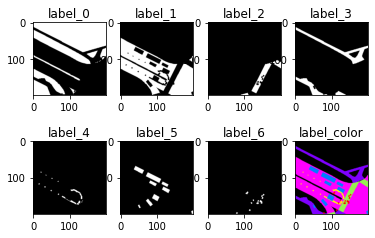

In [86]:
import matplotlib.pyplot as plt
plt.subplot(2,4,1)
plt.imshow(label_0)
plt.title('label_0')

plt.subplot(2,4,2)
plt.imshow(label_1)
plt.title('label_1')

plt.subplot(2,4,3)
plt.imshow(label_2)
plt.title('label_2')

plt.subplot(2,4,4)
plt.imshow(label_3)
plt.title('label_3')

plt.subplot(2,4,5)
plt.imshow(label_4)
plt.title('label_4')

plt.subplot(2,4,6)
plt.imshow(label_5)
plt.title('label_5')

plt.subplot(2,4,7)
plt.imshow(label_6)
plt.title('label_6')

plt.subplot(2,4,8)
plt.imshow(label_color)
plt.title('label_color')

plt.show()

In [91]:
# 测试模型
from torch import nn
import torchvision

In [108]:
base_model = 'resnet101'
pretrain = 'imagenet'
base_model = getattr(torchvision.models, base_model)(True if pretrain == 'imagenet' else False)

In [94]:
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [117]:
new_model = torch.nn.Sequential(*(list(base_model.children())[:-2]))
print(new_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [122]:
input_test = torch.randn(1, 3, 450, 800) # (N, C, H, W)
output = new_model(input_test)
print(output.shape)

torch.Size([1, 2048, 15, 25])


In [126]:
# input img in a list and then concatenate
input_1 = torch.randn(450, 800, 3)
input_2 = torch.randn(450, 800, 3)
input_3 = torch.randn(450, 800, 3)
img_group = [input_1, input_2, input_3]
#input_con = np.concatenate([np.array(x)[:, :, ::-1] for x in img_group], axis=2)
input_con = np.concatenate(img_group, axis=2)
print(input_con.shape)

(450, 800, 9)


In [128]:
class ToTorchFormatTensor(object):
    """ Converts a PIL.Image (RGB) or numpy.ndarray (H x W x C) in the range [0, 255]
    to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] """
    def __init__(self, div=True):
        self.div = div

    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic).permute(2, 0, 1).contiguous()
        else:
            # handle PIL Image
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
            img = img.view(pic.size[1], pic.size[0], len(pic.mode))
            # put it from HWC to CHW format
            # yikes, this transpose takes 80% of the loading time/CPU
            img = img.transpose(0, 1).transpose(0, 2).contiguous()
        return img.float().div(255) if self.div else img.float()

ToTensor = ToTorchFormatTensor
input_tensor = ToTensor()(input_con)
print(input_tensor.shape)

torch.Size([9, 450, 800])


In [130]:
input_new = torch.randn(1, 9, 450, 800)
sample_len = 3
input_view = input_new.view((-1, sample_len) + input_new.size()[-2:])
print(input_view.shape)

torch.Size([3, 3, 450, 800])


In [100]:
base_model.last_layer_name = 'fc'
#base_model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
base_model.avgpool = nn.AdaptiveAvgPool2d(1)
print(base_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [105]:
blocks = list(base_model.layer1.children())
blocks

[BasicBlock(
   (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicBlock(
   (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 ),
 BasicBlock(
   (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [106]:
len(blocks)


3

In [101]:
n_segment = 3
n_segment_list = [n_segment] * 4
n_segment_list

[3, 3, 3, 3]